In [0]:
import numpy as np
import pandas as pd
from google.colab import drive

from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import math
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams["figure.figsize"] = 12.8, 9.6

In [1552]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1553]:
!ls "/content/gdrive/My Drive/Colab Notebooks/orientation"

20-march	  box_1_output.npy  box_3_output.npy
box_0_output.npy  box_2_output.npy  box_4_output.npy


In [0]:
def load_point_cloud():
  df = np.load("/content/gdrive/My Drive/Colab Notebooks/orientation/20-march/60/point_cloud_err_6.npy")
  return df.T

In [1555]:
points = load_point_cloud()
# transpose the data
points = points.T
print(points)
DEPTH_SCALE = 2000
CUT_OFF_SCALE = 1
NUM_CLUSTER = 3

[[3.41000000e+02 3.41000000e+02 3.41000000e+02 ... 4.99000000e+02
  4.99000000e+02 4.99000000e+02]
 [8.32000000e+02 8.33000000e+02 8.34000000e+02 ... 1.02700000e+03
  1.02800000e+03 1.02900000e+03]
 [3.19000006e-01 3.19000006e-01 3.18000019e-01 ... 2.75000006e-01
  0.00000000e+00 0.00000000e+00]]


In [0]:
def scale_input_data(point_list, scale_factor):
  return point_list*scale_factor

In [0]:
def filter_input_data_for_outliers(points):
  points[2] = points[2]*DEPTH_SCALE
  std_dev = np.std(points[2])
  mean = np.mean(points[2])

  print("standard deviation = ", std_dev)
  print("mean = ", mean)
  print("array shape = ", points.shape)

  filtered_array = np.array([])
  for index in range(len(points[2])):
    if points[2][index] < (mean + std_dev*CUT_OFF_SCALE) and points[2][index] > (mean - std_dev*CUT_OFF_SCALE):
      filtered_array = np.append(filtered_array, points[:, index], axis=0)
  
  # print("flat array length = ", len(filtered_array)/3)
  filtered_array = np.reshape(filtered_array, (int(len(filtered_array)/3), 3))
  print("new array shape = ", filtered_array.T.shape)
  return filtered_array.T

In [0]:
def remove_minor_clusters(filtered_points):
  cluster_points = [(filtered_points[0][index], filtered_points[2][index]) for index in range(len(filtered_points[0]))]
  scaler = StandardScaler()
  X = scaler.fit_transform(cluster_points)
  kmeans = KMeans(n_clusters=NUM_CLUSTER, n_init=10).fit(X)
  # print(kmeans.labels_)

  data = {"x": filtered_points[0], "y": filtered_points[1], "depth": filtered_points[2], "cluster": kmeans.labels_}
  df = pd.DataFrame(data)
  mean = df.groupby('cluster').count().mean()['depth']
  cluster_depth = df.groupby('cluster').count()['depth']
  cluster_depth = cluster_depth.where(cluster_depth > mean).dropna()
  # print(cluster_depth)
  # print(cluster_depth.keys())

  df = df[df['cluster'].isin(cluster_depth.keys())]

  # plot before cluster removal
  # scatter = plt.scatter(filtered_points[0], filtered_points[2], c=kmeans.labels_)
  # plt.legend(*scatter.legend_elements(num=7),
  #                     loc="upper right", title="Cluster")

  cluster_filtered_points = np.array([df['x'].tolist(), 
                                     df['y'].tolist(),
                                     df['depth'].tolist()])

  # plot after cluster removal
  # scatter = plt.scatter(cluster_filtered_points[0], cluster_filtered_points[2])
  # plt.legend(*scatter.legend_elements(num=7),
  #                     loc="upper right", title="Cluster")
    
  return cluster_filtered_points

In [1559]:
# filtered_points = scale_input_data(points, DEPTH_SCALE)
filtered_points = filter_input_data_for_outliers(points)
print("array shape = ", filtered_points.shape)
# filtered_points = remove_minor_clusters(filtered_points)
print("new array shape =", filtered_points.shape)

print(filtered_points)

standard deviation =  196.43903098697857
mean =  512.4035013668514
array shape =  (3, 7708)
new array shape =  (3, 6749)
array shape =  (3, 6749)
new array shape = (3, 6749)
[[ 341.          341.          341.         ...  499.
   499.          499.        ]
 [ 832.          833.          834.         ... 1025.
  1026.         1027.        ]
 [ 638.00001144  638.00001144  636.00003719 ...  552.00004578
   550.00001192  550.00001192]]


In [0]:
def distance(X,p):
    plane = p[0:3]
    distance = (plane*X.T).sum(axis=1) - p[3]
    return distance / np.linalg.norm(plane)

def residuals(params, signal, X):
    return distance(X, params)

In [0]:
def get_initial_plane_coefficient():
    """ 
    plane equation is aX + bY + cZ = d
    plane_coeff = [a, b, c, d]
    """
    plane_coeff = [0.506645455682, -0.185724560275, -1.43998120646, 1.37626378129]
    
    return plane_coeff

In [0]:
plane_coeff = get_initial_plane_coefficient()

In [0]:
# solution = leastsq(residuals, plane_coeff, args=(None, points))[0]
solution = leastsq(residuals, plane_coeff, args=(None, filtered_points))[0]

In [1564]:
print("a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])

a =  4.800301246267278 b =  -18.651840297546197 c =  -27.36150833128096 d =  -31305.05902276868


In [1565]:
print("old offset = ", (distance(points, plane_coeff)**2).sum())
print("new offset =  ", (distance(points, solution)**2).sum())

old offset =  1890466506.5177333
new offset =   227077388.25491077


In [0]:
def get_plane_point_cloud(a, b, c, d):
    if a != 0:
        x = np.linspace(0,500,10)
    else:
        x = np.linspace(0,0,10)
        
    if b != 0:
        y = np.linspace(0,500,10)
    else:
        y = np.linspace(0,0,10)
    
    if c != 0:
        X,Y = np.meshgrid(x,y)
        Z = (d - (a*X + b*Y))/c
    else:
        z = np.linspace(0,0,10)
        X,Z = np.meshgrid(x, z)
        Y = (d - (a*X + c*Z))/b

    return X, Y, Z

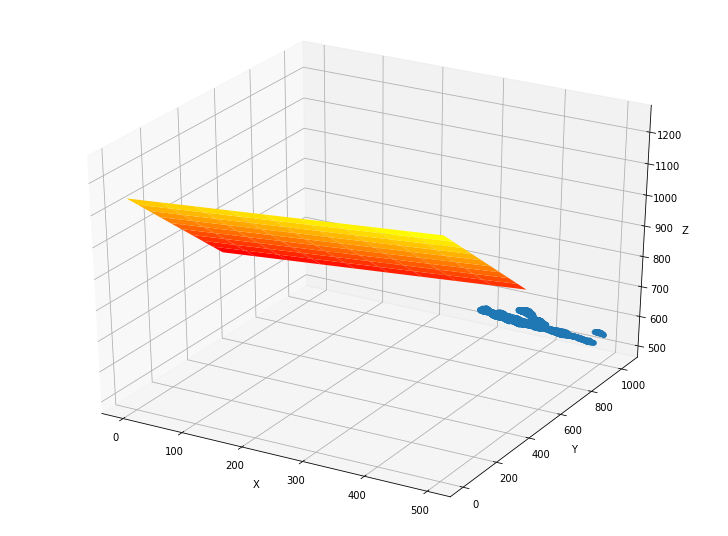

In [1567]:
fig = plt.figure()

# ax = plt.axes(projection='3d')
ax = fig.gca(projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# original plot point cloud
# xs = points[0]
# ys = points[1]
# zs = points[2]

# point cloud excluding outliers
xs = filtered_points[0]
ys = filtered_points[1]
zs = filtered_points[2]

ax.scatter(xs, ys, zs, linewidth=1)

# # plot inferred plan
X, Y, Z = get_plane_point_cloud(solution[0], solution[1], solution[2], solution[3])
ax.plot_surface(X, Y, Z, alpha=1, cmap='autumn')

# plot reference plan
ref_plane_a = 0
ref_plane_b = 0
ref_plane_c = 1
ref_plane_d = 1

X, Y, Z = get_plane_point_cloud(ref_plane_a, ref_plane_b, ref_plane_c, ref_plane_d)
# ax.plot_surface(X, Y, Z, alpha=0, cmap='winter')

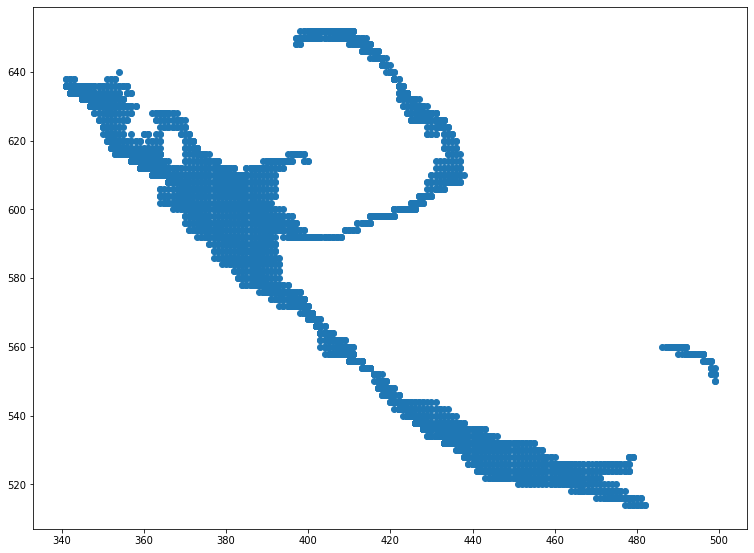

In [1568]:
plt.scatter(filtered_points[0], filtered_points[2])

(array([ 639.,  891.,  254.,  394.,  515.,  925., 1232.,  857.,  664.,
         378.]), array([513.99999857, 527.79999971, 541.60000086, 555.400002  ,
        569.20000315, 583.00000429, 596.80000544, 610.60000658,
        624.40000772, 638.20000887, 652.00001001]), <a list of 10 Patch objects>)

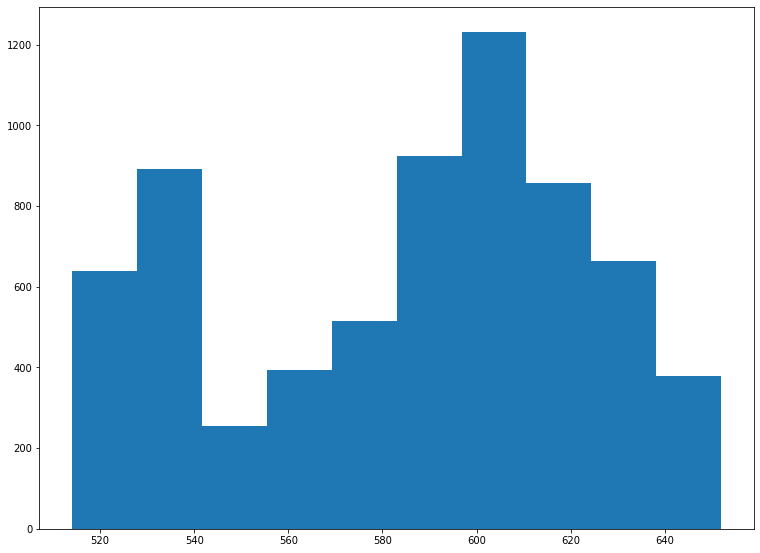

In [1569]:
plt.hist(filtered_points[2])

In [0]:
def calculate_angle_of_line_with_axis(a, b):
  line_function = np.poly1d([a, b])
  x = [100, 200]
  y = line_function(x)
  angle = np.rad2deg(np.arctan2(y[-1] - y[0], x[-1] - x[0]))
  # print("orientation angle is = ", angle)
  return angle

In [0]:
def calculate_angle_between_planes(a1, b1, c1, a2, b2, c2):
    n = abs(a1*a2 + b1*b2 + c1*c2)
    d1 = math.sqrt(a1*a1 + b1*b1 + c1*c1)
    d2 = math.sqrt(a2*a2 + b2*b2 + c2*c2)
    cos_angle = round(n/(d1*d2), 10)
    print("n = ", n, " d1 = ", d1, " d2 = ", d2, "angle in radians = ", cos_angle)
    angle = math.degrees(math.acos(cos_angle))
    return angle

In [1572]:
print("Inferred ->  a = ", solution[0], "b = ", solution[1], "c = ", solution[2], "d = ", solution[3])
print("Reference -> a = ", ref_plane_a, "b = ", ref_plane_b, "c = ", ref_plane_c, "d = ", ref_plane_d)

angle = calculate_angle_between_planes(solution[0], solution[1], solution[2], ref_plane_a, ref_plane_b, ref_plane_c)
print("angle between plane is %d degrees"%(angle))

Inferred ->  a =  4.800301246267278 b =  -18.651840297546197 c =  -27.36150833128096 d =  -31305.05902276868
Reference -> a =  0 b =  0 c =  1 d =  1
n =  27.36150833128096  d1 =  33.460217822106905  d2 =  1.0 angle in radians =  0.8177325227
angle between plane is 35 degrees


In [0]:
regression = np.polyfit(filtered_points[0], filtered_points[2], deg=1)

In [1574]:
angle = calculate_angle_of_line_with_axis(regression[0], regression[1])
print("orientation angle is = ", angle)

orientation angle is =  -38.105143008196826
